<a href="https://colab.research.google.com/github/ThomLlobEce/Portfolio/blob/master/MOA_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanisms of Action (Moa) Prediction

Ece 2020/2021 Ing5 BDA grp1:


*   Antoniadis Pablo
*   Llobregat Thomas



In [1]:
import numpy as np
import pandas as pd

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorboard.plugins.hparams import api as hp

from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
BATCH_SIZE = 32

# Read metadata about our data

In [3]:
features = pd.read_csv("/content/drive/MyDrive/Ing5/Deep-learning/train_features.csv", nrows=10)
targets = pd.read_csv("/content/drive/MyDrive/Ing5/Deep-learning/train_targets_scored.csv", nrows=10)

cols_features = features.columns
cols_targets = targets.columns

num_features = len(cols_features)
num_targets = len(cols_targets)

print("Number of features:" , num_features)
print("Number of targets:" , num_targets)

Number of features: 876
Number of targets: 207


In [4]:
features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [5]:
targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Reading data using tf.data.experimental.CsvDataset

In [6]:
features_types = [str(), str(), str(), str()] + [float()]*(num_features-4)
targets_types = [str()] + [float()]*(num_targets-1)

features = tf.data.experimental.CsvDataset("/content/drive/MyDrive/Ing5/Deep-learning/train_features.csv",
                                           record_defaults=features_types,
                                           #select_cols
                                           header=True)

targets = tf.data.experimental.CsvDataset("/content/drive/MyDrive/Ing5/Deep-learning/train_targets_scored.csv",
                                          record_defaults=targets_types,
                                          header=True)

dataset = tf.data.Dataset.zip((features, targets))

In [7]:
# split dataset into train and val
dataset_size = dataset.reduce(0, lambda x, _: x + 1).numpy()

train_size = int(0.7*dataset_size)
val_size = dataset_size - train_size

train = dataset.take(train_size)
val = dataset.skip(train_size)
val = dataset.take(val_size)

train_size = train.reduce(0, lambda x, _: x + 1).numpy()
val_size = val.reduce(0, lambda x, _: x + 1).numpy()

print("Full dataset size:", dataset_size)
print("Train dataset size:", train_size)
print("Val dataset size:", val_size)

Full dataset size: 23814
Train dataset size: 16669
Val dataset size: 7145


In [8]:
def _preprocess_line(features, targets):
    # Pack the result into a dictionary
    features = dict(zip(cols_features, features))
    features.pop('sig_id')

    targets = tf.stack(targets[1:])
    
    return features, targets

train = train.map(_preprocess_line)
train = train.batch(BATCH_SIZE)

val = val.map(_preprocess_line)
val = val.batch(BATCH_SIZE)

In [9]:
for feature_batch, label_batch in train.take(1):
    print('First 5 features:', list(feature_batch.keys())[:5])
    print('A batch of cp_types:', feature_batch['cp_type'].numpy())
    print('A batch of cp_times:', feature_batch['cp_time'].numpy())
    print('A batch of cp_dose:', feature_batch['cp_dose'].numpy())
    print('A batch of targets:', label_batch.numpy() ) 

First 5 features: ['cp_type', 'cp_time', 'cp_dose', 'g-0', 'g-1']
A batch of cp_types: [b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'ctl_vehicle' b'trt_cp'
 b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp' b'trt_cp']
A batch of cp_times: [b'24' b'72' b'48' b'48' b'72' b'24' b'24' b'48' b'48' b'48' b'72' b'48'
 b'48' b'48' b'72' b'48' b'48' b'24' b'72' b'48' b'48' b'48' b'72' b'72'
 b'72' b'48' b'72' b'48' b'48' b'72' b'72' b'48']
A batch of cp_dose: [b'D1' b'D1' b'D1' b'D1' b'D2' b'D1' b'D2' b'D1' b'D1' b'D2' b'D2' b'D2'
 b'D1' b'D2' b'D1' b'D1' b'D1' b'D2' b'D2' b'D1' b'D2' b'D1' b'D1' b'D1'
 b'D2' b'D1' b'D1' b'D2' b'D1' b'D1' b'D1' b'D2']
A batch of targets: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]

# Feature Engineering

As we can see in the dataframe we have two types of features:

**categorical features** represented by : 


*   cp_type => trt_cp or ctl_vehicle
*   cp_dose => D1 or D2
*   cp_time => 24 , 48 , 72


**numerical features** represented by :

*   g-n  (n E [0 , 771])
*   c-m (m E [0 , 99]) 

First we will map string values from a vocabulary to integer indices and one-hot encodes the features.

Secondly we will **not** normalize the numerical features because they are already very small values and not scattered.

In [10]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [11]:
all_inputs = []
encoded_features = []

In [12]:
# Categorical features encoded as string.
categorical_cols = ['cp_dose','cp_type','cp_time']
for header in categorical_cols:
  print(f"Encoding {header}")
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)



Encoding cp_dose
Encoding cp_type
Encoding cp_time


In [13]:
to_skip = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

for header in cols_features:
  if header not in to_skip:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='float32')
    all_inputs.append(categorical_col)
    encoded_features.append(categorical_col)


In [14]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([256, 512, 1024]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.5]))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [15]:
def train_test_model(hparams):
  all_features = tf.keras.layers.concatenate(encoded_features)
  x = tf.keras.layers.Dense(875, activation="relu")(all_features)
  x = tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation="relu")(x)
  x = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(x)
  output = tf.keras.layers.Dense(206)(x)
  model = tf.keras.Model(all_inputs, output)
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])
  
  Model_hist = model.fit(train, epochs=10, validation_data=val)
  return Model_hist

In [19]:
def run(hparams):
    hp.hparams(hparams)  # record the values used in this trial
    hist.append(train_test_model(hparams))

In [20]:
session_num = 0
hist = []

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in HP_DROPOUT.domain.values:
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_DROPOUT: dropout_rate
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run(hparams)
    session_num += 1

--- Starting trial: run-0
{'num_units': 256, 'dropout': 0.1}
Epoch 1/10
521/521 [==============================] - 57s 110ms/step - loss: 0.0276 - accuracy: 0.0915 - val_loss: 0.0158 - val_accuracy: 0.1372
Epoch 2/10
521/521 [==============================] - 59s 113ms/step - loss: 0.0155 - accuracy: 0.1501 - val_loss: 0.0130 - val_accuracy: 0.1968
Epoch 3/10
521/521 [==============================] - 64s 122ms/step - loss: 0.0125 - accuracy: 0.2161 - val_loss: 0.0102 - val_accuracy: 0.2742
Epoch 4/10
521/521 [==============================] - 60s 116ms/step - loss: 0.0095 - accuracy: 0.2979 - val_loss: 0.0073 - val_accuracy: 0.3930
Epoch 5/10
521/521 [==============================] - 63s 120ms/step - loss: 0.0066 - accuracy: 0.4035 - val_loss: 0.0048 - val_accuracy: 0.4572
Epoch 6/10
521/521 [==============================] - 62s 119ms/step - loss: 0.0042 - accuracy: 0.4889 - val_loss: 0.0030 - val_accuracy: 0.5093
Epoch 7/10
521/521 [==============================] - 63s 121ms/step 

# Model Variance & Bias Analysis

We chose to plot insights relative to the seventh model because it is the one with the highest accuracy on the validation data.

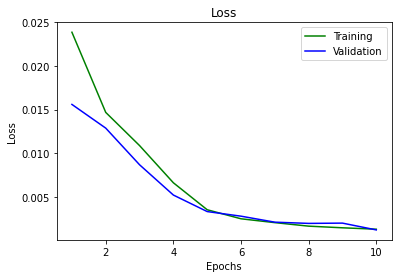

Final validation loss : 0.0011842433596029878


In [23]:
loss_train = hist[6].history['loss']
loss_validation = hist[6].history['val_loss']
epochs = range(1, len(hist[6].history['loss']) + 1)
plt.plot(epochs, loss_train, 'g', label='Training')
plt.plot(epochs, loss_validation, 'b', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()
print(f"Final validation loss : {hist[6].history['val_loss'][9]}")

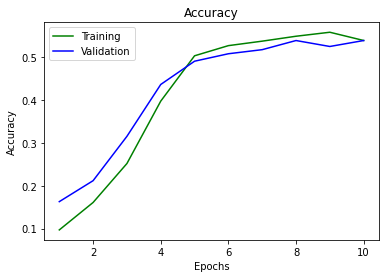

Final validation accuracy : 0.538


In [29]:
acc_train = hist[6].history['accuracy']
acc_validation = hist[6].history['val_accuracy']
epochs = range(1, len(hist[6].history['accuracy']) + 1)
plt.plot(epochs, acc_train, 'g', label='Training')
plt.plot(epochs, acc_validation, 'b', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()
print(f"Final validation accuracy : {hist[6].history['val_accuracy'][9]:.3f}")